In [79]:
## Importing required libraries 
# Data Management/Investigation
import pandas as pd
import numpy as np
import missingno as miss
from plotnine import *
import warnings
warnings.filterwarnings("ignore")

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.linear_model import LinearRegression as LM
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DTree
from sklearn import tree # For plotting the decision tree rules
from sklearn.ensemble import BaggingRegressor as Bag
from sklearn.ensemble import RandomForestRegressor as RF

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

In [86]:
## Reading in the data sets 
## Training data
train_dat = pd.read_csv("coding_discussions_ppol564_fall2021/06_coding_discussion/train_data.csv")
## Test data
test_dat = pd.read_csv("coding_discussions_ppol564_fall2021/06_coding_discussion/test_data.csv")
print("The dimensions of the training data set is : ", train_dat.shape)
print("The dimensions of the test data set is : ", test_dat.shape)
test_dat.shape

The dimensions of the training data set is :  (43590, 39)
The dimensions of the test data set is :  (14531, 39)


(14531, 39)

<AxesSubplot:>

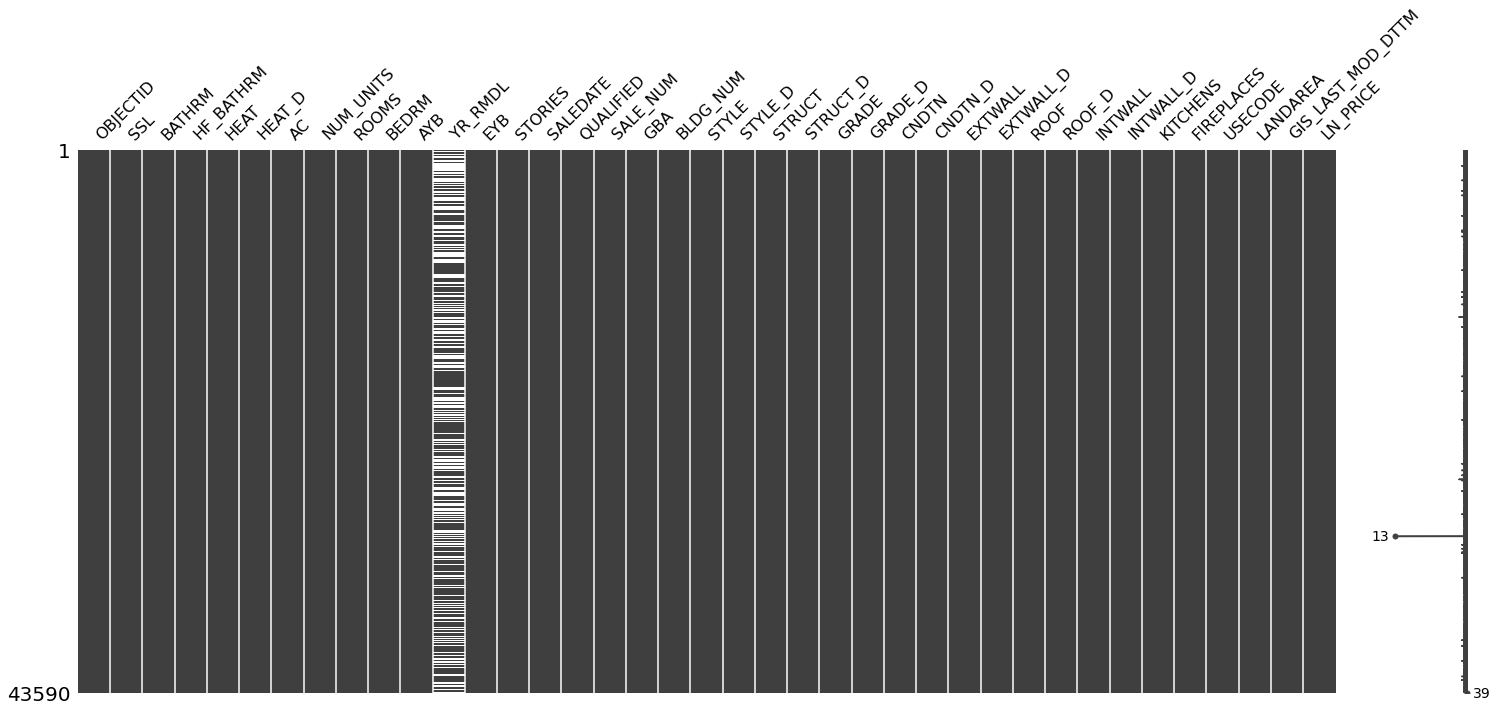

In [87]:
## Visualizing the missing values in the data set 
miss.matrix(train_dat)

To include the YR_RMDL information in the model without having to drop missing values or NaNs, we can create a dummy variable that encodes information on whether the house was remodeled or not. 

In [88]:
## Creating a dummy variable to see if the house was remodeled or not 
train_dat['REMODEL'] = np.where(np.isnan(train_dat['YR_RMDL']), 0, 1)

In [89]:
## Selecting the predictors and outcome variable 
dat = train_dat[['ROOMS', 'BEDRM', 'BATHRM', 'LANDAREA', 'STYLE', 'GRADE', 'STORIES', 'REMODEL', 'LN_PRICE']]
dat = dat[dat.LANDAREA > 0] ## Getting Land area > 0 since we will take the log 
dat.dropna(inplace = True) ## Dropping any NAs
y = dat['LN_PRICE'] ## Outcome variable 
np.all(np.isfinite(y))  ## Checking if all values are finite
y


X = dat[['ROOMS', 'BEDRM', 'BATHRM', 'LANDAREA', 'STYLE', 'GRADE', 'STORIES', 'REMODEL']]## Predictors  
X['LANDAREA'] = np.log(X['LANDAREA']) # Log land area (some house are on a lot of land, other on barely a plot)
np.all(np.isfinite(X))  ## Checking if all values are finite
X ## Displaying the predictor data frame 


,ROOMS,BEDRM,BATHRM,LANDAREA,STYLE,GRADE,STORIES,REMODEL
0,9.0,4.0,3.0,7.711549,4.0,5.0,2.0,1
1,7.0,3.0,2.0,8.255828,4.0,6.0,2.0,0
2,9.0,4.0,2.0,8.970305,6.0,6.0,2.5,1
3,6.0,3.0,1.0,7.915348,4.0,3.0,2.0,0
4,11.0,4.0,2.0,7.648263,4.0,5.0,2.0,1
...,...,...,...,...,...,...,...,...
43585,5.0,2.0,1.0,6.327937,4.0,4.0,2.0,1
43586,7.0,3.0,2.0,7.301822,4.0,5.0,2.0,1
43587,9.0,4.0,2.0,7.239215,7.0,4.0,3.0,1
43588,6.0,3.0,3.0,6.777647,4.0,4.0,2.0,1


In [78]:
## Model Pipeline 

# (1) Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=7, shuffle=True,random_state=111)

# (2)Specifying the preprocessing steps
preprocess = ColumnTransformer(transformers=[('num', pp.MinMaxScaler(), ['ROOMS', 'BEDRM', 'BATHRM', 'LANDAREA', 'STYLE', 'GRADE', 'STORIES', 'REMODEL'])])


# (3) Creating our model pipe 
pipe = Pipeline(steps=[('pre_process', preprocess),
                       ('model',None)])


# (4) Specify the models and their respective tuning parameters. 
# Note the naming convention here to reference the model key
search_space = [
    # Linear Model
    {'model' : [LM()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[10,15,20,25,30]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DTree()],
     'model__max_depth':[1,2,3,5]},
    
    # The Bagging decision tree model 
    {'model': [Bag()]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
     'model__max_depth':[1,2,3],
     'model__n_estimators':[500,1000,1250]},
]


# (5) Grid Search for tuning parameters 
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)

# (6) Fit the model to the training data
search.fit(X,y)

GridSearchCV(cv=KFold(n_splits=7, random_state=111, shuffle=True),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('pre_process', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', MinMaxScaler(copy=True, feature_range=(0, 1)), ['ROOMS', 'BEDRM', 'BATHRM', 'LANDAREA', 'STYLE', 'GRADE', 'STORIES', 'REMODEL'])])), ('model', None)]),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid=[{'model': [LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)]}, {'model': [KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=30, p=2,
          weights='uniform')], 'model_...ose=0, warm_start=False)], 'model__max_depth': [1, 2, 3], 'model__n_estimators': [500, 1000, 1250]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       s

In [90]:
## Best fit score 
search.best_score_

-0.4008869947665568

In [81]:
## Best model 
search.best_params_

{'model': KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=30, p=2,
           weights='uniform'), 'model__n_neighbors': 30}

In [82]:
## Getting the test data and making the same modifications as in training data
test_dat['REMODEL'] = np.where(np.isnan(test_dat['YR_RMDL']), 0, 1) ## REMODEL dummy variable 
test = test_dat[['ROOMS', 'BEDRM', 'BATHRM', 'LANDAREA', 'STYLE', 'GRADE', 'STORIES', 'REMODEL', 'LN_PRICE']]
test = test[test.LANDAREA > 0]
test.dropna(inplace = True)

test_y = test['LN_PRICE'] ## test y will be compared to the predictions

test_X = test[['ROOMS', 'BEDRM', 'BATHRM', 'LANDAREA', 'STYLE', 'GRADE', 'STORIES', 'REMODEL']] 
test_X['LANDAREA'] = np.log(test_X['LANDAREA'])


In [83]:
pred_y = search.predict(test_X) ## Getting the predictions for the test set from the best model 

In [84]:
m.mean_squared_error(test_y,pred_y) ## Getting the mean squared error 

0.3918252547001392

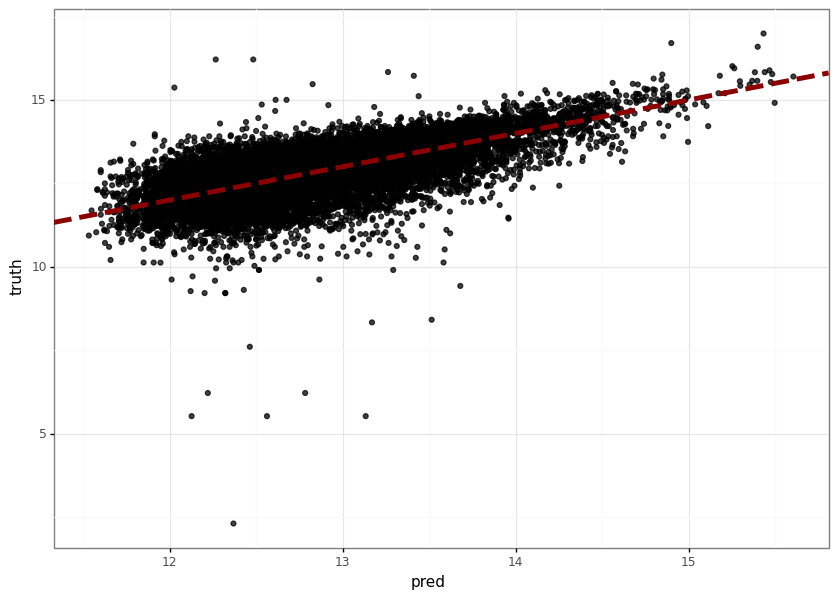

<ggplot: (-9223372036535316662)>

In [85]:
## Visualizing the predictions
(
    ggplot(pd.DataFrame(dict(pred=pred_y,truth=test_y)),
          aes(x='pred',y="truth")) +
    geom_point(alpha=.75) +
    geom_abline(linetype="dashed",color="darkred",size=2) +
    theme_bw() +
    theme(figure_size=(10,7))
)
